# Finalise model variables (predictors and predictands)

Weight the data by population and by state, then detrend.

In [1]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

import bottleneck

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "00:10:00"
cores = 12
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                                          
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.1:34809,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
import xarray as xr
import pandas as pd

In [6]:
%cd /g/data/w42/dr6273/work/demand_model//

import functions as fn

/g/data/w42/dr6273/work/demand_model


# Load population and state mask

In [7]:
pop_mask = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask.nc"
)["population_density"]

Scale so that this is weights between 0 and 1

In [8]:
pop_mask = (pop_mask - pop_mask.min()) / (pop_mask.max() - pop_mask.min())

In [9]:
pop_mask = pop_mask.chunk()

# Weight predictors and average over regions

We open the data differently depending on whether we need derived indices, which are available as zarr stores, or basic daily ERA5 data, which are separate netcdf files for each year.

In [10]:
def sel_NEM(ds, lat_name="lat", lon_name="lon"):
    """
    Select NEM region. Renames coords to lat/lon if not already.
    
    ds: dataset or array to sel on.
    lat_name, lon_name: names of lat/lon coords.
    """
    if lat_name != "lat":
        ds = ds.rename({lat_name: "lat"})
    if lon_name != "lon":
        ds = ds.rename({lon_name: "lon"})
        
    return ds.sel(lon=slice(125, 155), lat=slice(-10, -45))

In [11]:
def read_zarr(fp):
    """
    Open zarr collection of ERA5 data.
    
    fp: str, path to file.
    """
    return xr.open_zarr(fp, consolidated=False)

In [12]:
def zarr_read_and_sel(fp, lat_name="lat", lon_name="lon"):
    """
    Open zarr store, select NEM region and rename lat/lon.
    
    fp: str, path to file.
    lat_name, lon_name: names of lat/lon coords.
    """
    ds = read_zarr(fp)
    return sel_NEM(ds, lat_name, lon_name)

In [13]:
def open_daily(fp, lat_name="lat", lon_name="lon"):
    """
    Open multiple daily ERA5 files and preprocess to NEM region.
    
    fp: str, path to file. Should not include files, only the path to dir.
    lat_name, lon_name: names of lat/lon coords.
    """
    def preprocess(ds):
        ds = ds.rename({lat_name: "lat"})
        ds = ds.rename({lon_name: "lon"})
        return ds.sel(lon=slice(125, 155), lat=slice(-10, -45))
    
    ds = xr.open_mfdataset(
        fp,
        preprocess=preprocess,
        chunks={"time": "200MB"}
    )
    return ds

In [14]:
def read_data(fp, lat_name="lat", lon_name="lon"):
    """
    Reads and processes data to NEM region according to whether
    the data are stored as zarr or multiple netcdf files.
    
    fp: str, path to file.
    lat_name, lon_name: names of lat/lon coords.
    """
    if fp[-5:] == ".zarr":
        return zarr_read_and_sel(fp, lat_name=lat_name, lon_name=lon_name)
    elif fp[-3:] == ".nc":
        return open_daily(fp, lat_name=lat_name, lon_name=lon_name)
    else:
        raise ValueError("Unrecognised file type.")

In [15]:
def population_mean(ds, mask):
    """
    Compute the spatial average of population-weighted data for each region.
    
    ds: dataset or array to process
    mask: population mask/data
    """
    return ds.weighted(mask).mean(["lat", "lon"])

In [16]:
def detrend_ds(ds, var_name, new_var_name, dim="time"):
    """
    Detrend a dataset, retaining the mean, and rename variable.
    
    ds: dataset to detrend
    var_name: name of variable to detrend
    new_var_name: new name of detrended variable
    dim: dimension along which to detrend
    """
    mu = ds[var_name].mean(dim)
    dt = fn.detrend_dim(ds[var_name], dim)
    return (mu + dt).to_dataset(name=new_var_name)

In [17]:
def write(ds, fp):
    """
    Write to file and chunk to single chunk.
    
    ds: dataset to write.
    fp: str, path to write to.
    """
    ds = ds.chunk({"time": -1})
    # ds.to_zarr(fp, mode="w", consolidated=True)
    ds.to_netcdf(fp)

Dictionary of variables to process.

Organised with the variable name as the key, then a list as follows:
`[path_to_open, lat_name, lon_name, path_to_write, var_name, new_var_name]`

In [18]:
era_path = "/g/data/w42/dr6273/work/data/era5/"

In [19]:
write_path = "/g/data/w42/dr6273/work/projects/Aus_energy/demand_predictors/"

In [22]:
variables = {
    # "msdwswrf": [
    #     era_path + "msdwswrf/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "msdwswrf_era5_daily_1959-2022_NEM.nc",
    #     "msdwswrf",
    #     "msdwswrf"
    # ],
    # "10w": [
    #     era_path + "10w/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "10w_era5_daily_1959-2022_NEM.nc",
    #     "w10",
    #     "w10"
    # ],
    # "2t": [
    #     era_path + "2t/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "2t_era5_daily_1959-2022_NEM.nc",
    #     "t2m",
    #     "t2m"
    # ],
    "2tmax": [
        era_path + "2tmax/daily/*.nc",
        "latitude",
        "longitude",
        write_path + "2tmax_era5_daily_1959-2022_NEM.nc",
        "mx2t",
        "t2max"
    ],
    "2tmin": [
        era_path + "2tmin/daily/*.nc",
        "latitude",
        "longitude",
        write_path + "2tmin_era5_daily_1959-2022_NEM.nc",
        "mn2t",
        "t2min"
    ],
    # "mtpr": [
    #     era_path + "mtpr/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "mtpr_era5_daily_1959-2022_NEM.nc",
    #     "mtpr",
    #     "mtpr"
    # ],
    # "rh": [
    #     era_path + "rh/daily/*.nc",
    #     "latitude",
    #     "longitude",
    #     write_path + "rh_era5_daily_1959-2022_NEM.nc",
    #     "rh",
    #     "rh"
    # ],
    # "cdd": [
    #     era_path + "derived/cdd_24_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "cdd_24_era5_daily_1959-2022_NEM.nc",
    #     "cdd",
    #     "cdd"
    # ],
    # "hdd": [
    #     era_path + "derived/hdd_18_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "hdd_18_era5_daily_1959-2022_NEM.nc",
    #     "hdd",
    #     "hdd"
    # ],
    # "cdd3": [
    #     era_path + "derived/cdd_24_Aus_rollmean3_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "cdd_24_rollmean3_era5_daily_1959-2022_NEM.nc",
    #     "cdd",
    #     "cdd3"
    # ],
    # "cdd4": [
    #     era_path + "derived/cdd_24_Aus_rollmean4_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "cdd_24_rollmean4_era5_daily_1959-2022_NEM.nc",
    #     "cdd",
    #     "cdd4"
    # ],
    # "hdd3": [
    #     era_path + "derived/hdd_18_Aus_rollmean3_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "hdd_18_rollmean3_era5_daily_1959-2022_NEM.nc",
    #     "hdd",
    #     "hdd3"
    # ],
    # "hdd4": [
    #     era_path + "derived/hdd_18_Aus_rollmean4_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "hdd_18_rollmean4_era5_daily_1959-2022_NEM.nc",
    #     "hdd",
    #     "hdd4"
    # ],
    # "2t3": [
    #     era_path + "derived/2t_Aus_rollmean3_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "2t_rollmean3_era5_daily_1959-2022_NEM.nc",
    #     "t2m",
    #     "t2m3"
    # ],
    # "2t4": [
    #     era_path + "derived/2t_Aus_rollmean4_era5_daily_1959-2022.zarr",
    #     "latitude",
    #     "longitude",
    #     write_path + "2t_rollmean4_era5_daily_1959-2022_NEM.nc",
    #     "t2m",
    #     "t2m4"
    # ]
}

Loop through and process

In [23]:
for key, values in zip(variables.keys(), variables.values()):
    ds = read_data(values[0], values[1], values[2])
    ds = population_mean(ds, pop_mask)
    ds = detrend_ds(ds, values[4], values[5])
    write(ds, values[3])

# Predictand - energy demand

Detrend is all thats necessary.

In [3]:
demand = pd.read_csv(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020.csv",
    index_col=0,
    parse_dates=True
)

Add a new NEM column

In [4]:
demand["NEM"] = demand.sum(axis=1)

In [5]:
demand.head()

,NSW,QLD,SA,TAS,VIC,NEM
timestamp,,,,,,
2010-01-01,200345.265,141770.410,30926.095,24913.555,124188.520,522143.845
2010-01-02,224883.275,154139.850,35463.230,27495.375,140836.955,582818.685
2010-01-03,205852.705,155611.165,33345.755,26704.820,135756.785,557271.230
2010-01-04,200358.115,144340.325,33998.165,27066.485,133162.885,538925.975
2010-01-05,202376.745,138618.890,33345.325,27855.585,131333.895,533530.440


NEM demand decreases over time. This looks to be consistent with data from OpenNEM, and possibly linked to the recent availability of rooftop solar. Without rooftop, this figure from OpenNEM would show a decrease. https://opennem.org.au/energy/nem/?range=all&interval=1y

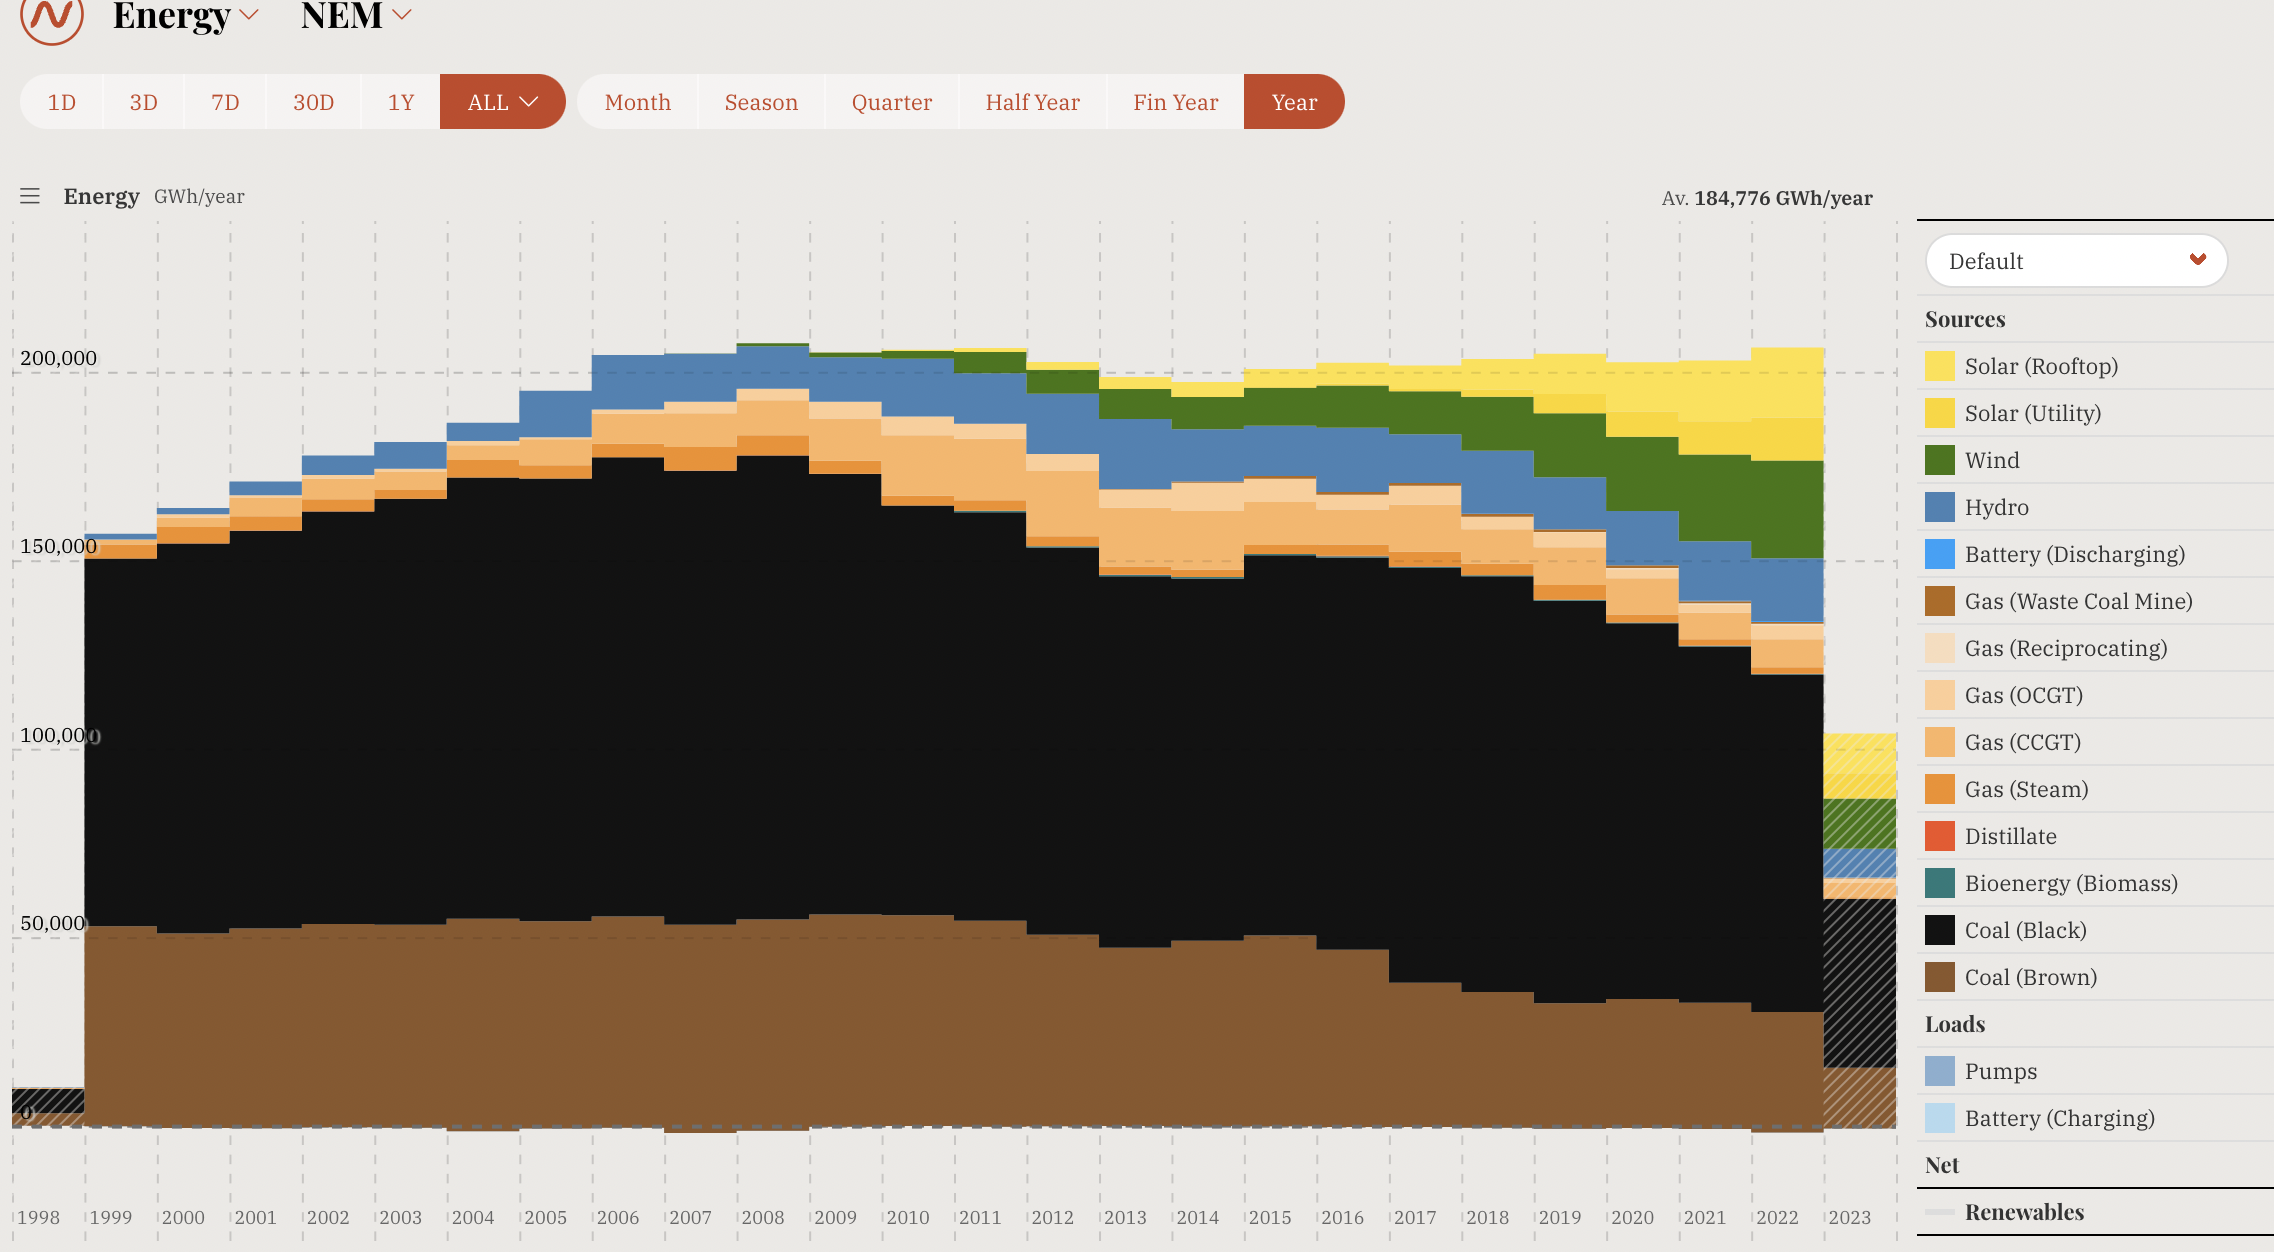

<AxesSubplot: xlabel='timestamp'>

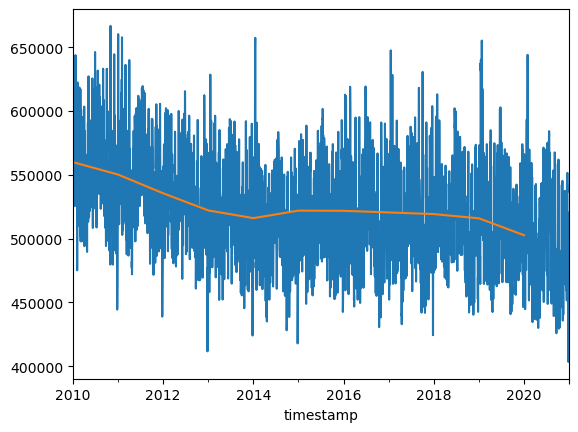

In [8]:
demand["NEM"].plot()
demand["NEM"].resample("Y").mean().plot()

Looks like we have the right ballpark. We're expecting ~200,000 GW/y, and we see ~1.9e8 / 1000 = 190,000 GW/y.

In [10]:
1.9e8 / 1000

190000.0

<AxesSubplot: xlabel='timestamp'>

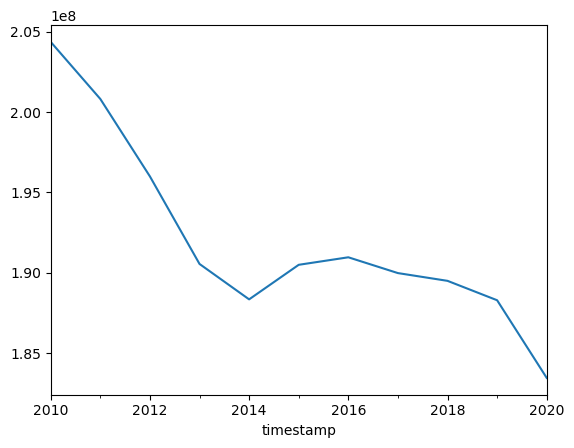

In [9]:
demand["NEM"].resample("Y").sum().plot()

Detrend using `xarray`

In [11]:
dem_da = xr.DataArray(
    demand.transpose(),
    dims=["region", "time"],
    coords={"region": demand.columns, "time": demand.index.values}
)

In [12]:
dem_dt = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

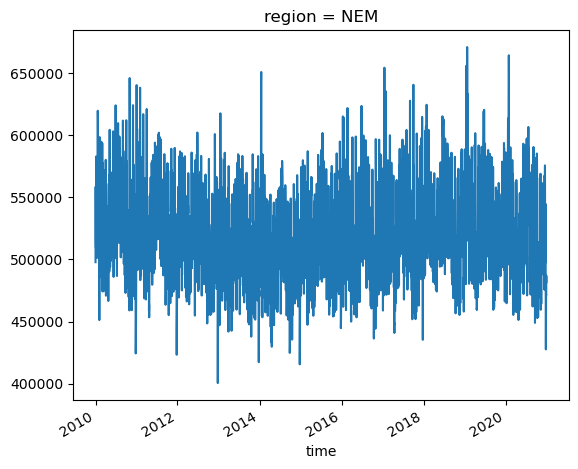

In [13]:
dem_dt.sel(region="NEM").plot()

Write to netcdf

In [15]:
dem_dt.to_dataset(name="demand_dt").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_detrended.nc"
)

# Close cluster

In [24]:
client.close()
cluster.close()